In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from collections import Counter, defaultdict

In [2]:
allowed_ext = ('.jpeg', '.jpg', '.bmp', '.png')
path = 'Data'
IMG_SIZE = 224

images = []
labels = []

try:
    classes = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    print(f"Classes trouvées: {classes}")
    
    for class_name in classes:
        class_path = os.path.join(path, class_name)
        image_files = os.listdir(class_path)
        
        for img_file in image_files:
            if img_file.lower().endswith(allowed_ext):
                img_path = os.path.join(class_path, img_file)
                img = cv2.imread(img_path)
                
                if img is not None:
                    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    images.append(img_resized)
                    labels.append(class_name)
            else:
                os.remove(os.path.join(class_path, img_file))
                
except Exception as e:
    print(f"Erreur: {e}")

Classes trouvées: ['meningioma', 'glioma', 'notumor', 'pituitary']


In [3]:
images, labels = shuffle(images, labels, random_state=42)

In [4]:
images = np.array(images)
labels = np.array(labels)
print(f"Shape des images: {images.shape}")
print(f"Shape des labels: {labels.shape}")

Shape des images: (7023, 224, 224, 3)
Shape des labels: (7023,)


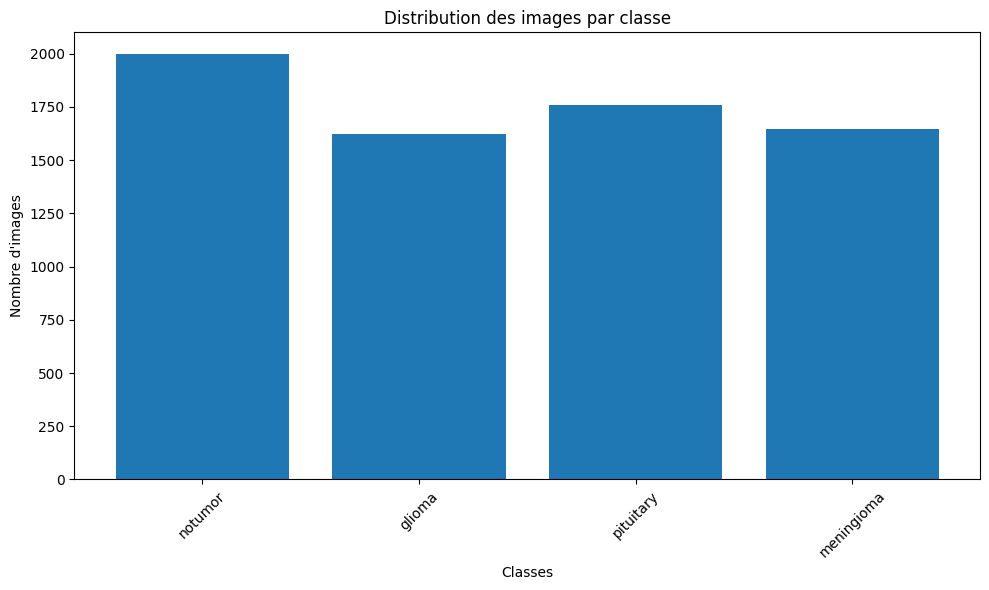

notumor: 2000 images
glioma: 1621 images
pituitary: 1757 images
meningioma: 1645 images


In [5]:
class_counts = Counter(labels)
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.title('Distribution des images par classe')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

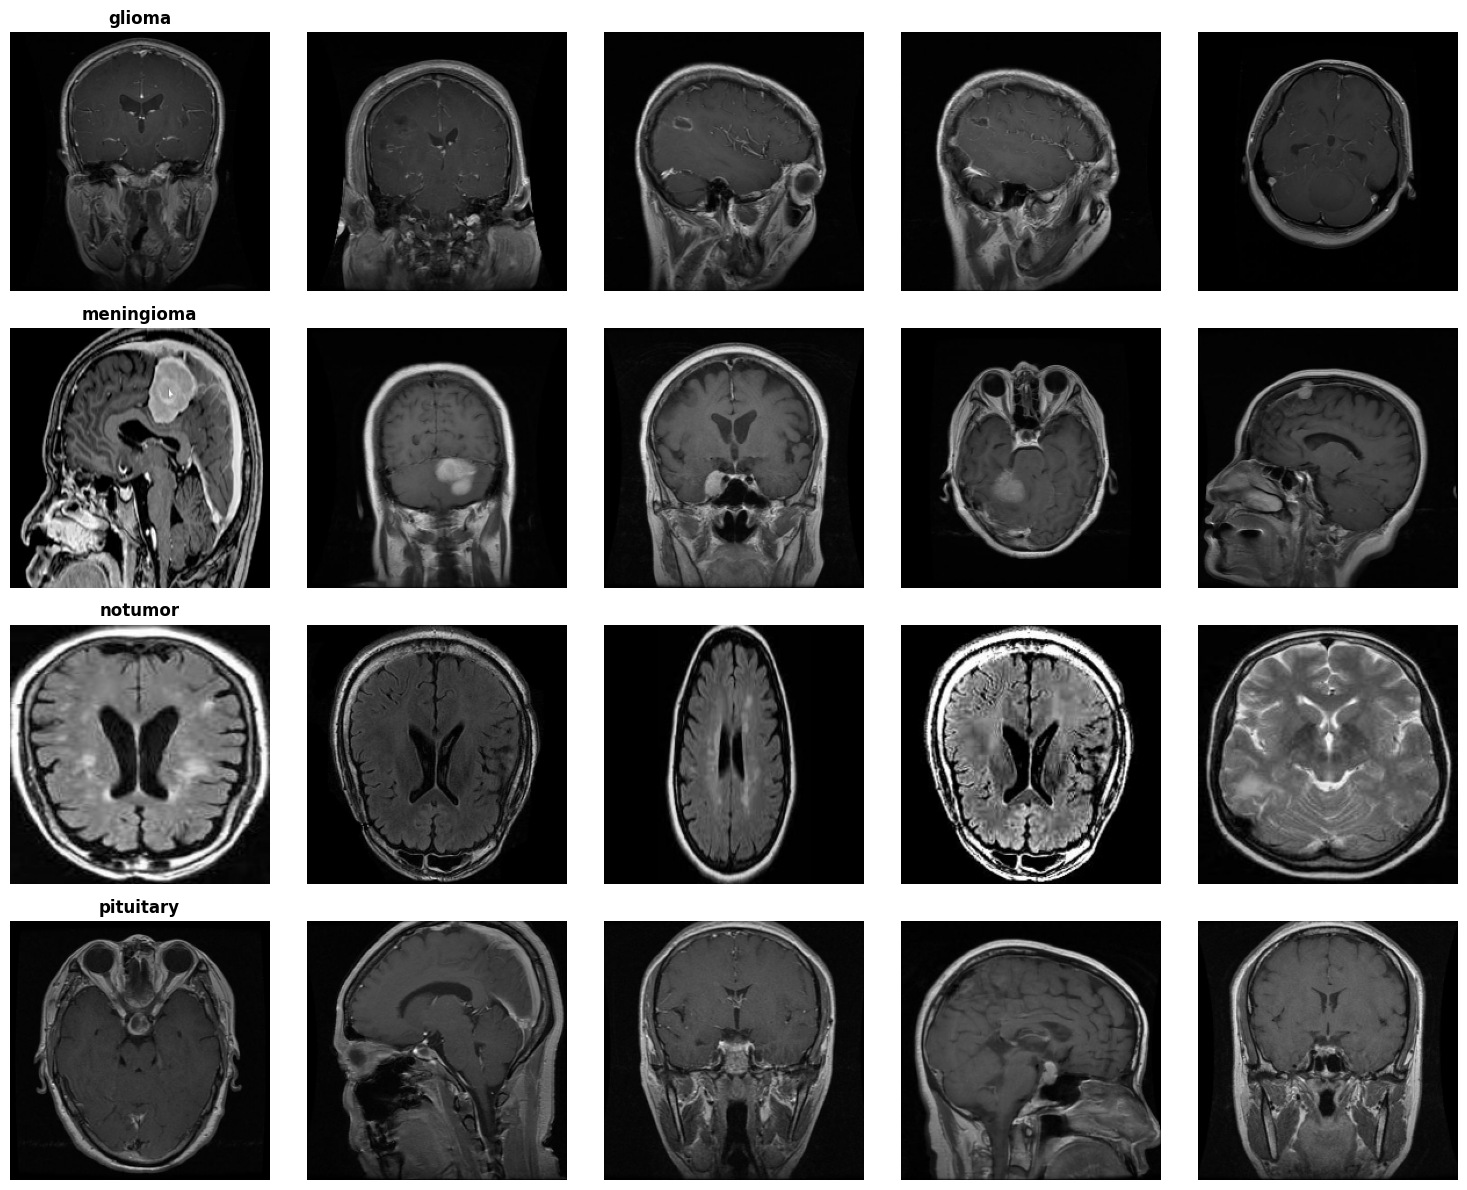

In [6]:
unique_classes = np.unique(labels)
fig, axes = plt.subplots(len(unique_classes), 5, figsize=(15, len(unique_classes) * 3))

for i, class_name in enumerate(unique_classes):
    class_indices = np.where(labels == class_name)[0][:5]
    
    for j, idx in enumerate(class_indices):
        ax = axes[i, j] if len(unique_classes) > 1 else axes[j]
        img_rgb = cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
        ax.axis('off')
        if j == 0:
            ax.set_title(f'{class_name}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [7]:
from sklearn.utils import resample

min_samples = min(class_counts.values())
max_samples = max(class_counts.values())
ratio = max_samples / min_samples

print(f"Déséquilibre: ratio max/min = {ratio:.2f}")

if ratio > 1.5:
    print("Rééquilibrage nécessaire")
    
    balanced_images = []
    balanced_labels = []
    
    for class_name in unique_classes:
        class_indices = np.where(labels == class_name)[0]
        class_images = images[class_indices]
        class_labels = labels[class_indices]
        
        resampled_images, resampled_labels = resample(
            class_images, class_labels, 
            n_samples=max_samples, 
            random_state=42
        )
        
        balanced_images.append(resampled_images)
        balanced_labels.append(resampled_labels)
    
    images = np.vstack(balanced_images)
    labels = np.concatenate(balanced_labels)
    
    images, labels = shuffle(images, labels, random_state=42)
    
    print(f"Nouvelle shape des images: {images.shape}")
    print(f"Nouvelle distribution: {Counter(labels)}")
else:
    print("Classes équilibrées")

Déséquilibre: ratio max/min = 1.23
Classes équilibrées


In [8]:
images

array([[[[5, 5, 5],
         [5, 5, 5],
         [5, 5, 5],
         ...,
         [5, 5, 5],
         [5, 5, 5],
         [5, 5, 5]],

        [[5, 5, 5],
         [5, 5, 5],
         [5, 5, 5],
         ...,
         [5, 5, 5],
         [5, 5, 5],
         [5, 5, 5]],

        [[4, 4, 4],
         [4, 4, 4],
         [4, 4, 4],
         ...,
         [5, 5, 5],
         [5, 5, 5],
         [5, 5, 5]],

        ...,

        [[7, 7, 7],
         [7, 7, 7],
         [7, 7, 7],
         ...,
         [8, 8, 8],
         [8, 8, 8],
         [8, 8, 8]],

        [[7, 7, 7],
         [7, 7, 7],
         [7, 7, 7],
         ...,
         [7, 7, 7],
         [8, 8, 8],
         [8, 8, 8]],

        [[7, 7, 7],
         [7, 7, 7],
         [7, 7, 7],
         ...,
         [7, 7, 7],
         [7, 7, 7],
         [7, 7, 7]]],


       [[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0,

In [9]:
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

print(f"Classes originales: {le.classes_}")
print(f"Encodage: {dict(zip(le.classes_, range(len(le.classes_))))}")
print(f"Shape des labels encodés: {labels_encoded.shape}")

Classes originales: ['glioma' 'meningioma' 'notumor' 'pituitary']
Encodage: {np.str_('glioma'): 0, np.str_('meningioma'): 1, np.str_('notumor'): 2, np.str_('pituitary'): 3}
Shape des labels encodés: (7023,)


In [10]:
from tensorflow.keras.utils import to_categorical

labels_categorical = to_categorical(labels_encoded)
print(f"Shape des labels catégoriels: {labels_categorical.shape}")
print(f"Exemple de label encodé: {labels_categorical[0]}")

2025-10-17 13:48:33.994914: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-17 13:48:34.165973: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Shape des labels catégoriels: (7023, 4)
Exemple de label encodé: [0. 0. 1. 0.]


2025-10-17 13:48:35.228825: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    zoom_range=0.1,
    brightness_range=[0.8, 1.2], 
    fill_mode='nearest'
)

images_par_classe = defaultdict(list)
for i, label in enumerate(labels):
    img = images[i].astype(np.float32)
    if len(img.shape) == 2: 
        img = np.expand_dims(img, -1)
    images_par_classe[label].append(img)

max_count = 2000
output_dir = "Data_Balanced"
os.makedirs(output_dir, exist_ok=True)

for label, imgs in images_par_classe.items():
    print(f"→ Classe {label} en cours")
    class_dir = os.path.join(output_dir, str(label))
    os.makedirs(class_dir, exist_ok=True)

    current = imgs.copy()
    while len(current) < max_count:
        current.append(datagen.random_transform(random.choice(imgs)))

    for i, img in enumerate(current[:max_count]):
        img = np.clip(img, 0, 255).astype(np.uint8)
        if img.shape[-1] == 1: 
            img = img.squeeze(-1)
        cv2.imwrite(os.path.join(class_dir, f"{label}_{i:04d}.jpg"), img)

print(f"Rééquilibrage terminé et sauvegardé dans : {output_dir}")

→ Classe notumor en cours
→ Classe glioma en cours
→ Classe pituitary en cours
→ Classe meningioma en cours
Rééquilibrage terminé et sauvegardé dans : Data_Balanced


In [12]:
balanced_path = 'Data_Balanced'
balanced_images = []
balanced_labels = []

try:
    balanced_classes = [d for d in os.listdir(balanced_path) if os.path.isdir(os.path.join(balanced_path, d))]
    print(f"Classes trouvées dans Data_Balanced: {balanced_classes}")
    
    for class_name in balanced_classes:
        class_path = os.path.join(balanced_path, class_name)
        image_files = os.listdir(class_path)
        
        for img_file in image_files:
            if img_file.lower().endswith(allowed_ext):
                img_path = os.path.join(class_path, img_file)
                img = cv2.imread(img_path)
                
                if img is not None:
                    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    balanced_images.append(img_resized)
                    balanced_labels.append(class_name)
                
except Exception as e:
    print(f"Erreur: {e}")

print(f"Total images chargées: {len(balanced_images)}")

Classes trouvées dans Data_Balanced: ['meningioma', 'glioma', 'notumor', 'pituitary']
Total images chargées: 8000


In [13]:
balanced_images, balanced_labels = shuffle(balanced_images, balanced_labels, random_state=42)

In [14]:
balanced_images = np.array(balanced_images)
balanced_labels = np.array(balanced_labels)
print(f"Shape des images équilibrées: {balanced_images.shape}")
print(f"Shape des labels équilibrés: {balanced_labels.shape}")

Shape des images équilibrées: (8000, 224, 224, 3)
Shape des labels équilibrés: (8000,)


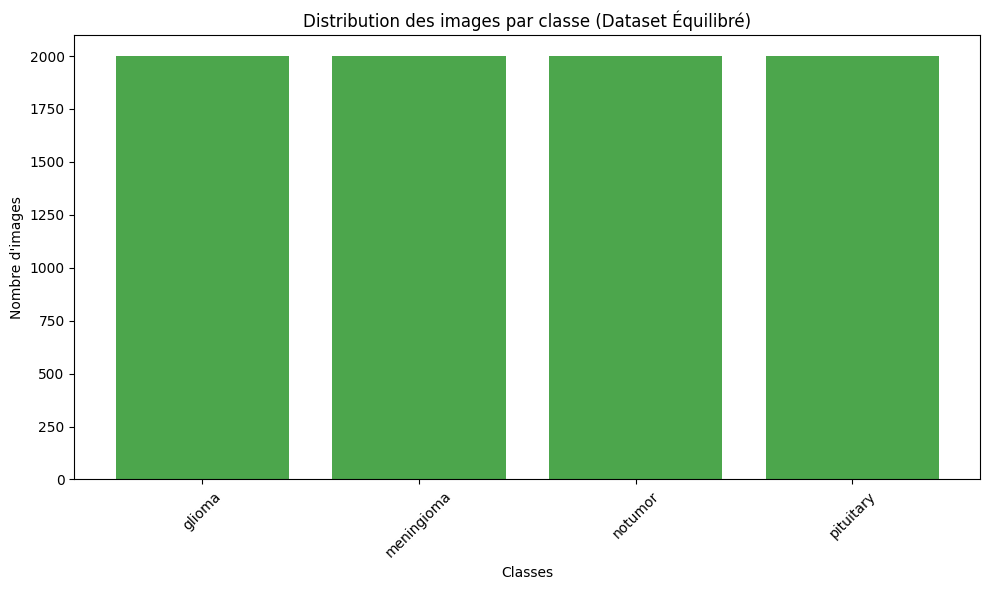

glioma: 2000 images
meningioma: 2000 images
notumor: 2000 images
pituitary: 2000 images


In [15]:
balanced_class_counts = Counter(balanced_labels)
plt.figure(figsize=(10, 6))
plt.bar(balanced_class_counts.keys(), balanced_class_counts.values(), color='green', alpha=0.7)
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.title('Distribution des images par classe (Dataset Équilibré)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

for class_name, count in balanced_class_counts.items():
    print(f"{class_name}: {count} images")

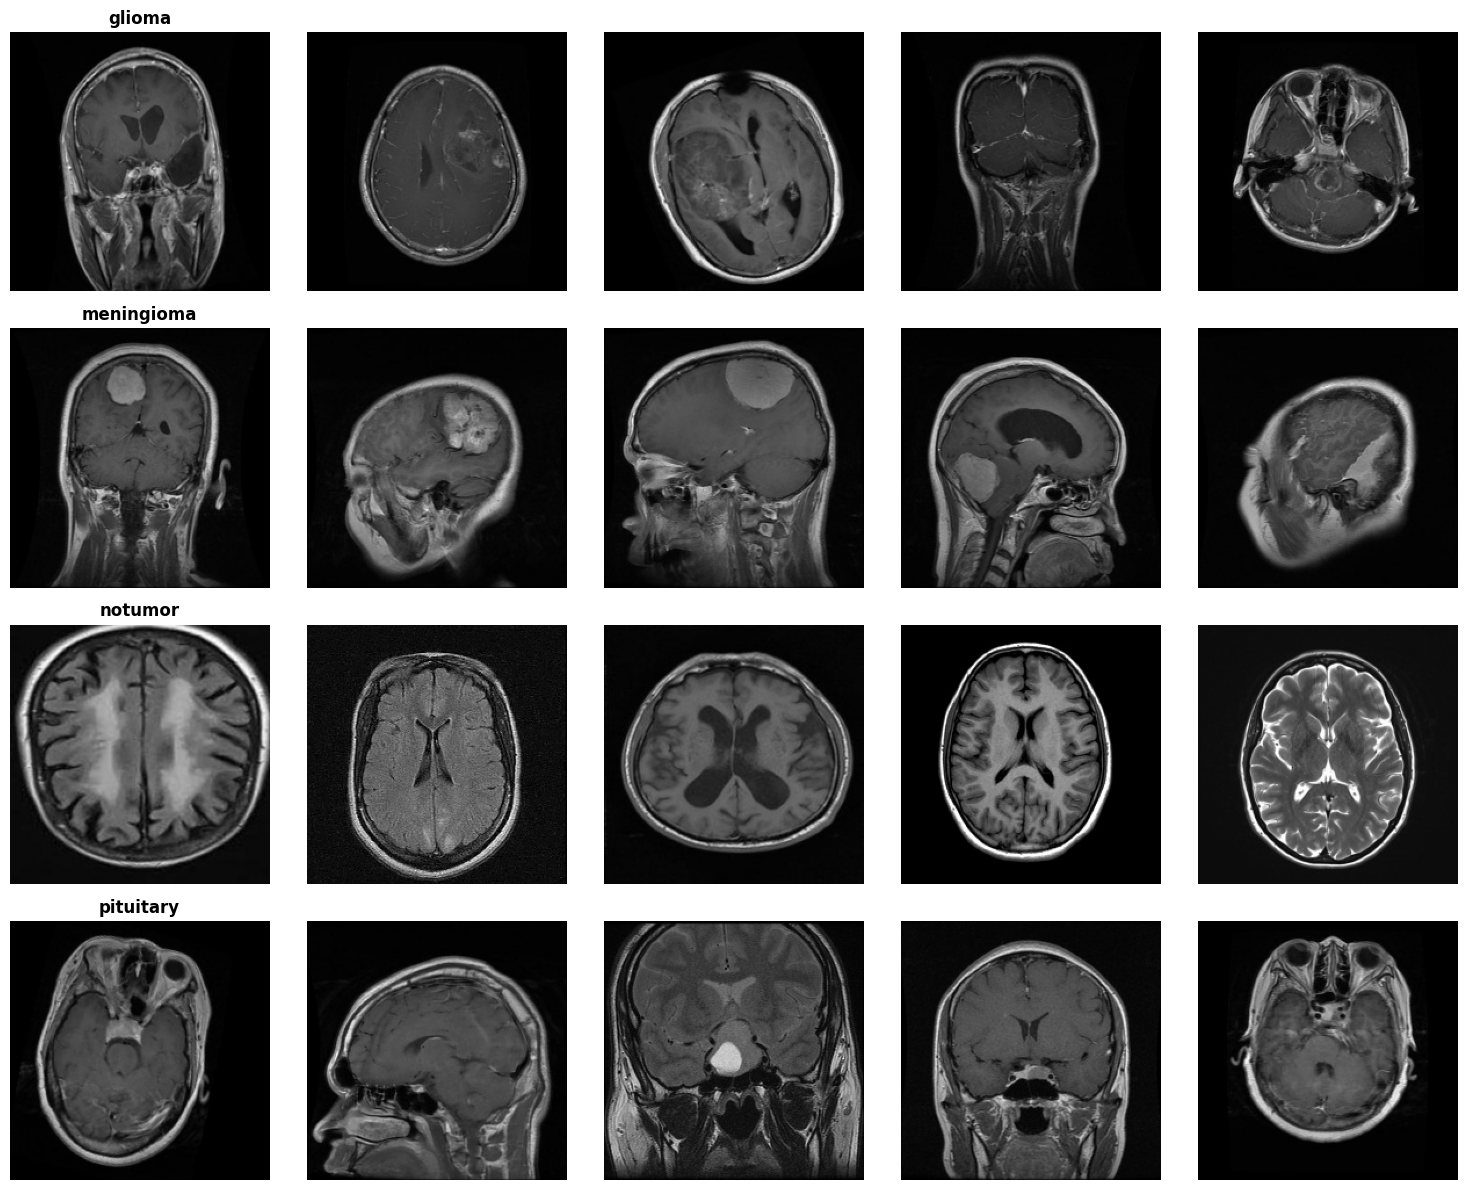

In [16]:
balanced_unique_classes = np.unique(balanced_labels)
fig, axes = plt.subplots(len(balanced_unique_classes), 5, figsize=(15, len(balanced_unique_classes) * 3))

for i, class_name in enumerate(balanced_unique_classes):
    class_indices = np.where(balanced_labels == class_name)[0][:5]
    
    for j, idx in enumerate(class_indices):
        ax = axes[i, j] if len(balanced_unique_classes) > 1 else axes[j]
        img_rgb = cv2.cvtColor(balanced_images[idx], cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
        ax.axis('off')
        if j == 0:
            ax.set_title(f'{class_name}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [17]:
balanced_le = LabelEncoder()
balanced_labels_encoded = balanced_le.fit_transform(balanced_labels)

print(f"Classes originales: {balanced_le.classes_}")
print(f"Encodage: {dict(zip(balanced_le.classes_, range(len(balanced_le.classes_))))}")
print(f"Shape des labels encodés: {balanced_labels_encoded.shape}")

Classes originales: ['glioma' 'meningioma' 'notumor' 'pituitary']
Encodage: {np.str_('glioma'): 0, np.str_('meningioma'): 1, np.str_('notumor'): 2, np.str_('pituitary'): 3}
Shape des labels encodés: (8000,)


In [18]:
balanced_labels_encoded

array([0, 0, 1, ..., 1, 3, 3], shape=(8000,))

In [19]:
balanced_labels_categorical = to_categorical(balanced_labels_encoded)
print(f"Shape des labels catégoriels: {balanced_labels_categorical.shape}")
print(f"Exemple de label encodé: {balanced_labels_categorical[0]}")
print(f"\nDataset équilibré prêt pour l'entraînement du CNN!")

Shape des labels catégoriels: (8000, 4)
Exemple de label encodé: [1. 0. 0. 0.]

Dataset équilibré prêt pour l'entraînement du CNN!


In [20]:
balanced_images_normalized = balanced_images / 255.0
print(f"Images normalisées: min={balanced_images_normalized.min()}, max={balanced_images_normalized.max()}")
print(f"Shape finale: {balanced_images_normalized.shape}")

Images normalisées: min=0.0, max=1.0
Shape finale: (8000, 224, 224, 3)


In [21]:
labels_encoded

array([2, 0, 0, ..., 2, 3, 1], shape=(7023,))

In [22]:
balanced_images_normalized

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'))
model.add(MaxPooling2D((2, 2))) # Output: 112x112

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2))) 

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2))) 


model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2))) 

model.add(Flatten())




/home/epsilon/Desktop/folder_0/projects/sprint_1/D-tection_Cancer_C-r-bral_CNN/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-17 13:48:50.650364: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-10-17 13:48:50.650392: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-10-17 13:48:50.650395: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic informat

In [24]:
balanced_labels_categorical

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], shape=(8000, 4))

In [25]:
from sklearn.model_selection import train_test_split


X = balanced_images_normalized
y = balanced_labels_categorical


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=balanced_labels
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


from collections import Counter
print("Distribution train:", Counter(np.argmax(y_train, axis=1)))
print("Distribution test:", Counter(np.argmax(y_test, axis=1)))

'''
os.makedirs('splits', exist_ok=True)
np.savez_compressed('splits/balanced_splits.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
print("Splits saved to splits/balanced_splits.npz")'''

X_train shape: (6400, 224, 224, 3)
X_test shape: (1600, 224, 224, 3)
y_train shape: (6400, 4)
y_test shape: (1600, 4)
Distribution train: Counter({np.int64(2): 1600, np.int64(1): 1600, np.int64(3): 1600, np.int64(0): 1600})
Distribution test: Counter({np.int64(3): 400, np.int64(2): 400, np.int64(1): 400, np.int64(0): 400})


'\nos.makedirs(\'splits\', exist_ok=True)\nnp.savez_compressed(\'splits/balanced_splits.npz\', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)\nprint("Splits saved to splits/balanced_splits.npz")'

In [26]:

model.add(Dense(128 , activation ='relu') )
model.add(Dropout(0.5))
model.add(Dense(4 , activation = 'softmax' ))


In [27]:

model.compile(optimizer='adam' , loss= 'categorical_crossentropy' , metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,811,588 (25.98 MB)

 Trainable params: 6,811,588 (25.98 MB)

 Non-trainable params: 0 (0.00 B)

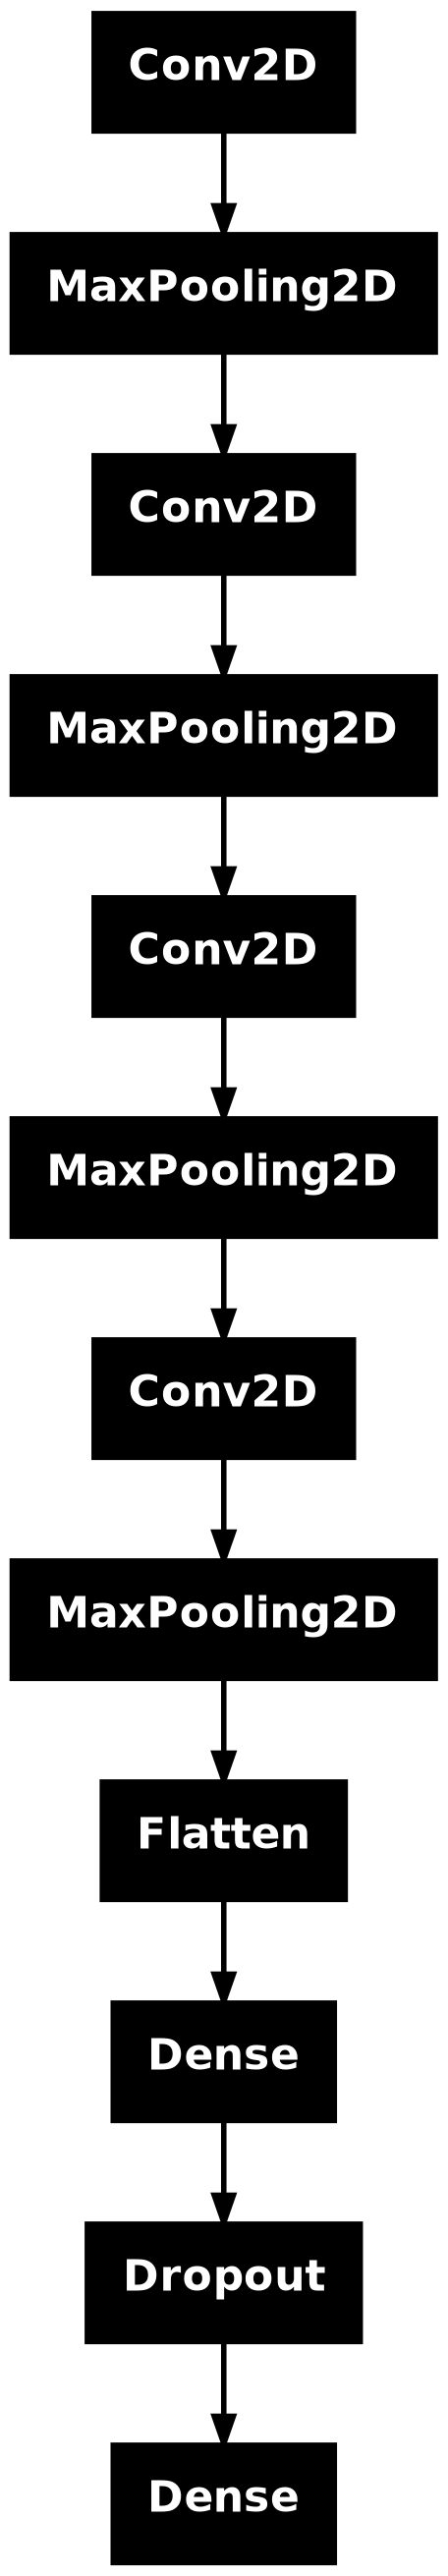

In [29]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [30]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr  = ReduceLROnPlateau(monitor = 'val_loss' , factor = 0.2 , patient=3)



In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint

best_model = ModelCheckpoint(
    filepath='best_model.keras',
    monitor = 'val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',

)

In [32]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test , y_test),
    epochs=9,
    callbacks=[reduce_lr]
)

Epoch 1/9
200/200 ━━━━━━━━━━━━━━━━━━━━ 74s 361ms/step - accuracy: 0.6625 - loss: 0.8011 - val_accuracy: 0.7419 - val_loss: 0.5850 - learning_rate: 0.0010
Epoch 2/9
200/200 ━━━━━━━━━━━━━━━━━━━━ 70s 351ms/step - accuracy: 0.7966 - loss: 0.5095 - val_accuracy: 0.8275 - val_loss: 0.4169 - learning_rate: 0.0010
Epoch 3/9
200/200 ━━━━━━━━━━━━━━━━━━━━ 70s 352ms/step - accuracy: 0.8491 - loss: 0.3789 - val_accuracy: 0.8338 - val_loss: 0.3962 - learning_rate: 0.0010
Epoch 4/9
200/200 ━━━━━━━━━━━━━━━━━━━━ 70s 351ms/step - accuracy: 0.8842 - loss: 0.2921 - val_accuracy: 0.8963 - val_loss: 0.2733 - learning_rate: 0.0010
Epoch 5/9
200/200 ━━━━━━━━━━━━━━━━━━━━ 69s 343ms/step - accuracy: 0.9186 - loss: 0.2139 - val_accuracy: 0.9044 - val_loss: 0.2643 - learning_rate: 0.0010
Epoch 6/9
200/200 ━━━━━━━━━━━━━━━━━━━━ 69s 343ms/step - accuracy: 0.9345 - loss: 0.1753 - val_accuracy: 0.9225 - val_loss: 0.2349 - learning_rate: 0.0010
Epoch 7/9
200/200 ━━━━━━━━━━━━━━━━━━━━ 69s 343ms/step - accuracy: 0.9488 - l

In [33]:
predictions = model.predict(X_test)

50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step


In [34]:
predicted_classes = np.argmax(predictions, axis=1)

In [35]:
predictions

array([[7.1702759e-09, 2.9570017e-06, 2.1122157e-10, 9.9999702e-01],
       [6.9096597e-05, 9.3536070e-03, 9.9057722e-01, 1.3576103e-07],
       [2.9822612e-02, 9.7017741e-01, 2.3460851e-11, 6.7486530e-11],
       ...,
       [2.8633387e-04, 4.2577941e-04, 3.0332283e-06, 9.9928492e-01],
       [9.8434514e-01, 1.2397069e-02, 4.4228036e-05, 3.2136035e-03],
       [9.9999690e-01, 3.0794547e-06, 4.5784185e-11, 2.4293721e-08]],
      shape=(1600, 4), dtype=float32)

In [36]:
y_test

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], shape=(1600, 4))

In [37]:
from sklearn.metrics import classification_report, confusion_matrix
true_labels = np.argmax(y_test, axis=1)

report = classification_report(true_labels, predicted_classes)

print(report)

              precision    recall  f1-score   support

           0       0.97      0.87      0.92       400
           1       0.85      0.91      0.88       400
           2       0.95      0.99      0.97       400
           3       0.97      0.95      0.96       400

    accuracy                           0.93      1600
   macro avg       0.93      0.93      0.93      1600
weighted avg       0.93      0.93      0.93      1600



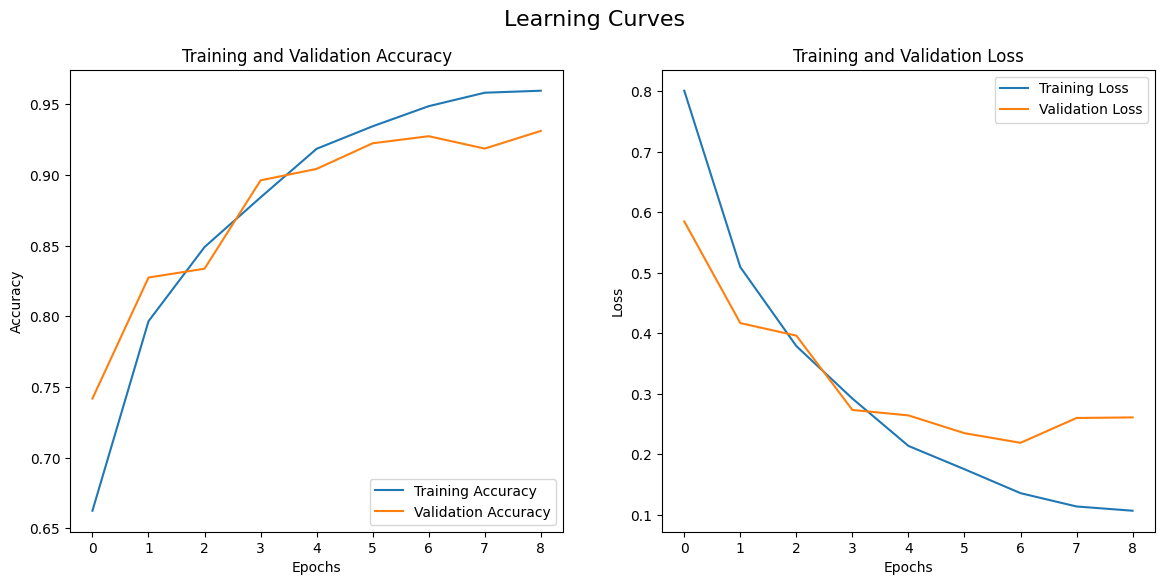

In [38]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))


plt.figure(figsize=(14, 6))


plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')


plt.suptitle('Learning Curves', fontsize=16)
plt.show()

In [40]:


cm = confusion_matrix(true_labels , predicted_classes)



In [41]:
cm

array([[349,  47,   0,   4],
       [ 11, 364,  17,   8],
       [  0,   3, 396,   1],
       [  1,  16,   2, 381]])

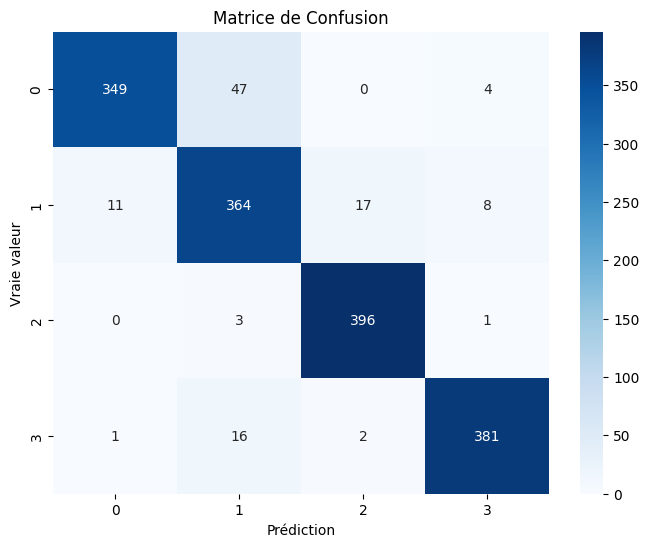

In [ ]:
import seaborn as sns


class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prédiction')
plt.ylabel('Vraie valeur')
plt.title('Matrice de Confusion')
plt.show()

Nombre de prédictions correctes : 1490
Nombre de prédictions incorrectes : 110

--- Exemples de Prédictions Correctes ---


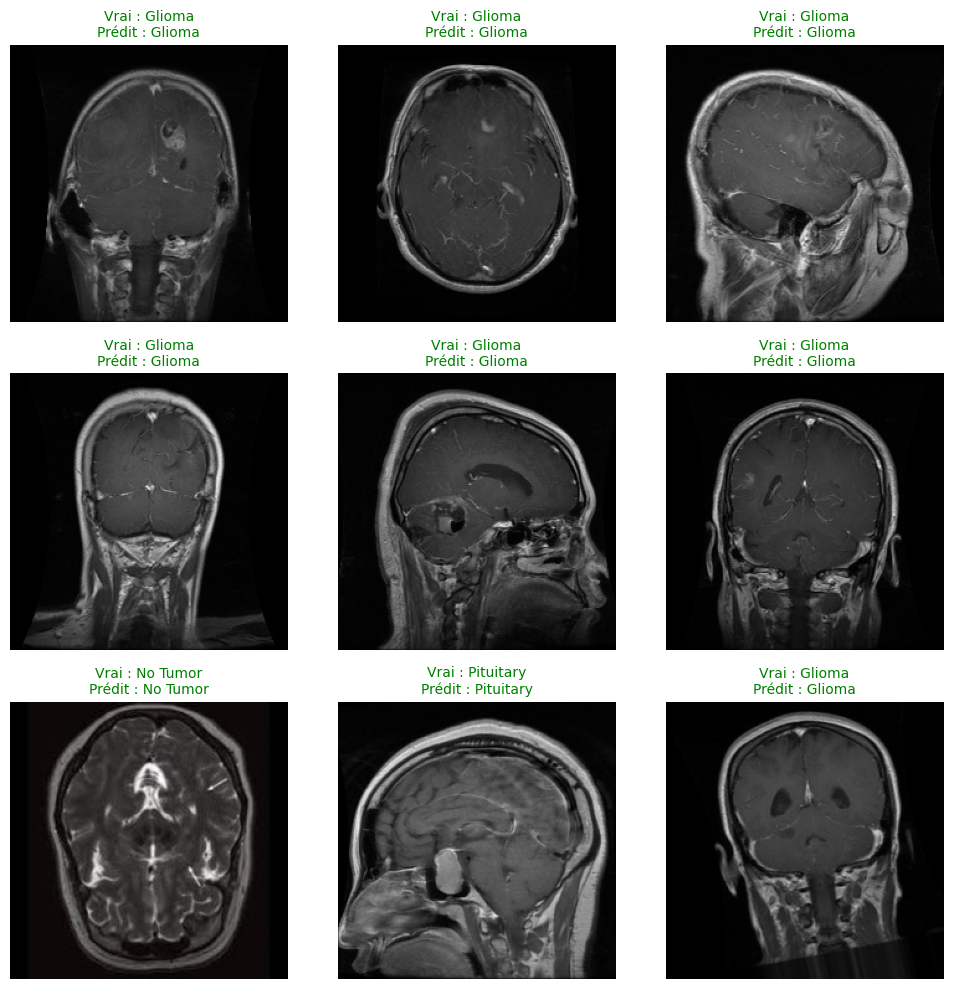


--- Exemples de Prédictions Incorrectes ---


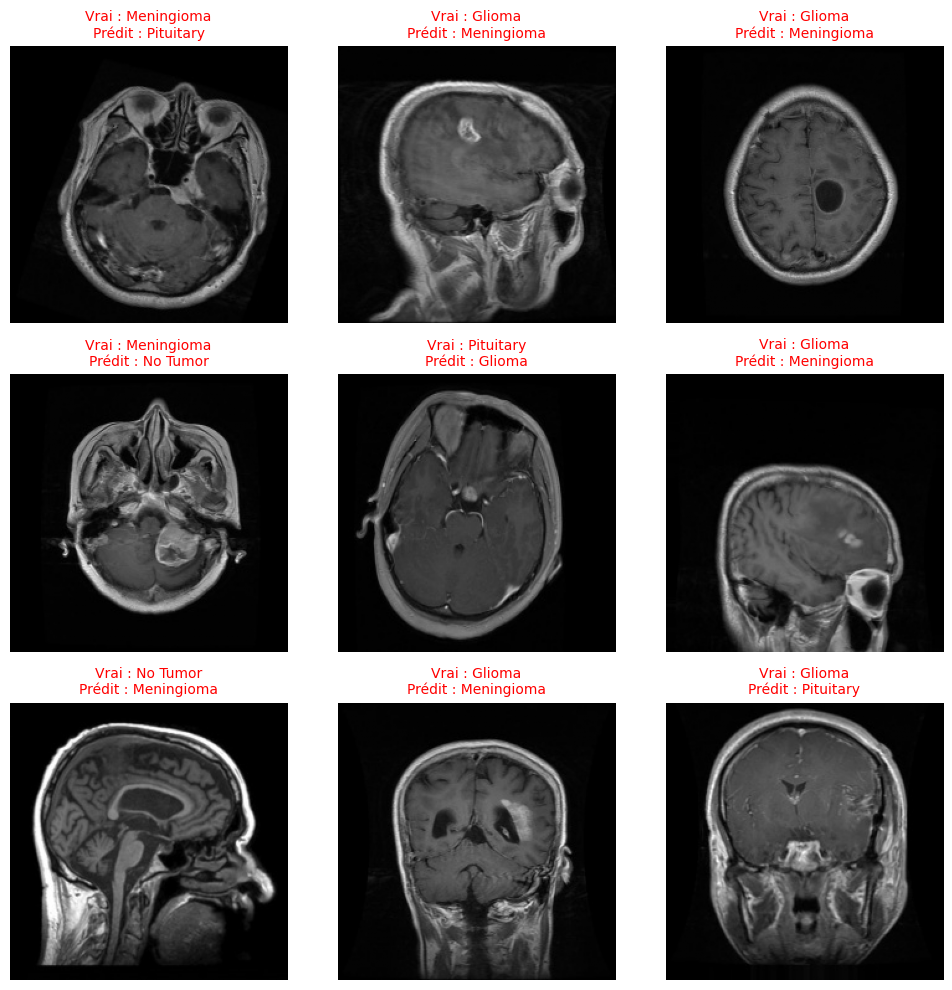

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

correct_indices = np.where(predicted_classes == true_classes)[0]
incorrect_indices = np.where(predicted_classes != true_classes)[0]

print(f"Nombre de prédictions correctes : {len(correct_indices)}")
print(f"Nombre de prédictions incorrectes : {len(incorrect_indices)}")



print("\n--- Exemples de Prédictions Correctes ---")
plt.figure(figsize=(10, 10))

for i, idx in enumerate(random.sample(list(correct_indices), 9)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[idx])
    plt.axis('off')
    
    true_label = class_names[true_classes[idx]]
    predicted_label = class_names[predicted_classes[idx]]
    
    plt.title(f"Vrai : {true_label}\nPrédit : {predicted_label}", color='green', fontsize=10)

plt.tight_layout()
plt.show()




plt.figure(figsize=(10, 10))

for i, idx in enumerate(random.sample(list(incorrect_indices), 9)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[idx])
    plt.axis('off')
    
    true_label = class_names[true_classes[idx]]
    predicted_label = class_names[predicted_classes[idx]]
    
    plt.title(f"Vrai : {true_label}\nPrédit : {predicted_label}", color='red', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow import keras
model.save('my_model.h5')




AttributeError: module 'tensorflow.keras' has no attribute 'saving'

In [ ]:
model.save('my_model.keras')